# Double Moon Experiment: T Off 1000

In [1]:
import sys
sys.path.insert(1, '../_tools/')
import torch as th
import torch.nn as nn
import numpy as np
from utils.tensordata import TDataset, TDataloader, PosNeg_Bootstrap_TDataloader
from utils.model_selection import GridSearchCV, RandomSearchCV, Fixed, LogUniform
from twomoon import TwoMoon
from ffa import FFA_withEntropy
import matplotlib.pyplot as plt

exp_name = 'T Off 1000'

seed = 42
th.manual_seed(seed)
np.random.seed(seed)
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

### Data

In [2]:
Ndata = 1000
twomoon = TwoMoon(noise=0.)
x, y = twomoon.sample(Ndata)
x, y = th.from_numpy(x).float().to(device), th.from_numpy(y).long().to(device)
DT = TDataset(x, y)
DS, TS = DT.random_split(0.8)
TR, VL = DS.random_split(0.8)

# Dataloaders
batch_size = 128
DS_dl = DS.dataloader()
TR_dl = TR.dataloader()
VL_dl = VL.dataloader()
TS_dl = TS.dataloader()
TR_pndl = PosNeg_Bootstrap_TDataloader(TR, batch_size=batch_size)
DS_pndl = PosNeg_Bootstrap_TDataloader(DS, batch_size=batch_size)

### Model

In [3]:
Model = FFA_withEntropy

### Kernel Scale

The value found in the 'T on' experiment

In [4]:
kern_sc = 30.270066166537696

***

### Preliminary Screening

***

### Model Selection + Final Retraining

In [5]:
grid = {
    'Nclasses': [2],
    'A': [(4, 1000, 1000, 1000)],
    'f_hid': [nn.ReLU()],
    'lr_hot': [0.3],
    'lr_cold': [0.001],
    'momentum': [0.98], 
    'weight_decay': np.geomspace(1e-7, 1e-3, 5).tolist(),
    'temperature': [0],
    'kernel_scale': [kern_sc], # the value found in 'T on' experiment, to compare the value of H
    'Nepochs': [300]
}
ModelSelection = GridSearchCV(Model, grid, device, N_trials_per_point=3)      
ModelSelection.run(TR_dl, VL_dl, TR_pndl)
ModelSelection.save("model selection results/" + exp_name + ".txt")
print(ModelSelection)
print("Note: E == 1 - accuracy")

# Final Retraining
M = Model(ModelSelection.results[0]['hyp']).to(device)
print('\n' + '-'*20 + "Final Retraining" + '-'*20)
M.fit(DS_pndl)
print(f"acc(TR) = {(1-M.TS_loop(DS_dl))*100:.3g} %")
th.save(M, 'final models/' + exp_name + '.pt')

GridSearchCV: 100%|██████████| 5/5 [05:15<00:00, 63.15s/it]


The winner is:
hyp: {
 Nclasses: 2,
 A: (4, 1000, 1000, 1000),
 f_hid: ReLU(),
 lr_hot: 0.3,
 lr_cold: 0.001,
 momentum: 0.98,
 weight_decay: 1e-07,
 temperature: 0,
 kernel_scale: 30.270066166537696,
 Nepochs: 300,
}
E(VL) = 0 +- 0 (sample size = 3)
E(TR) = 0.0020833 +- 0.0018 (sample size = 3)

Note: E == 1 - accuracy

--------------------Final Retraining--------------------
acc(TR) = 99.1 %


***

### Analysis

Note: noisy curves are expected, due to bootstrap and random generation of different negative data at each epoch.

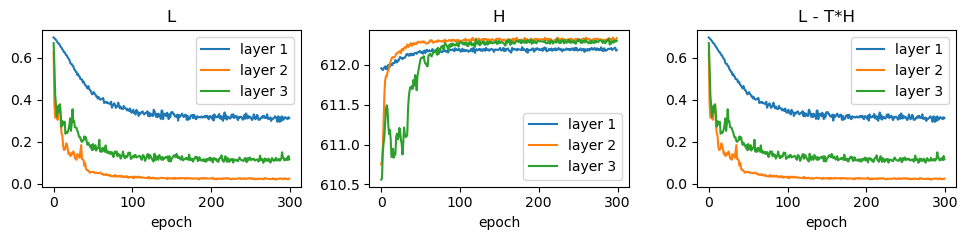

In [6]:
M = th.load('final models/' + exp_name + '.pt').to(device)
M.plot_curve()

#### Double Moon Plots

gather     accuracy%
[1, 1, 1]  97.5
[0, 1, 1]  98
[1, 0, 0]  86.5
[0, 1, 0]  100
[0, 0, 1]  95.5


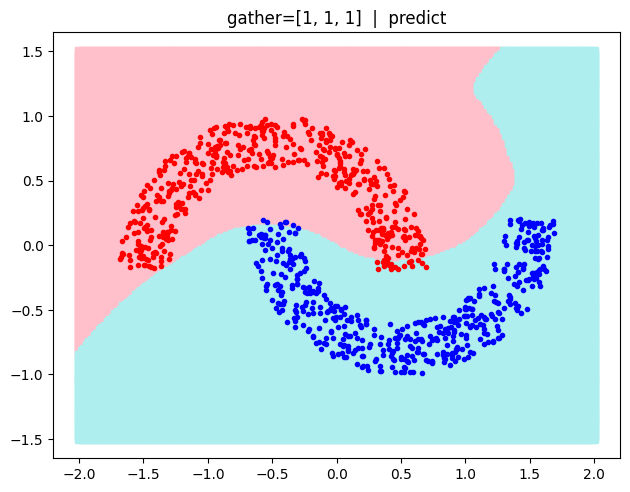

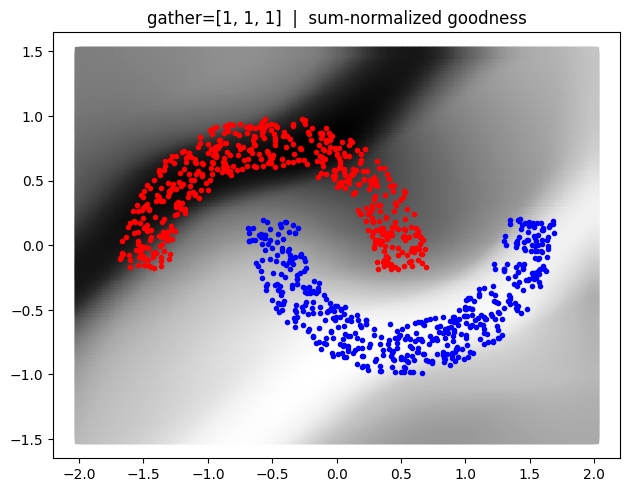

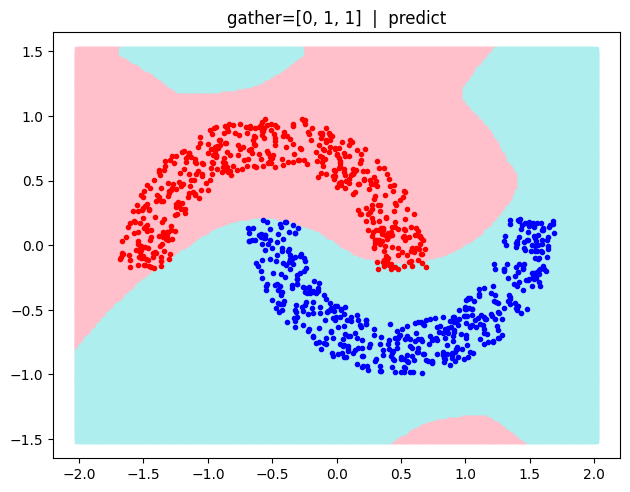

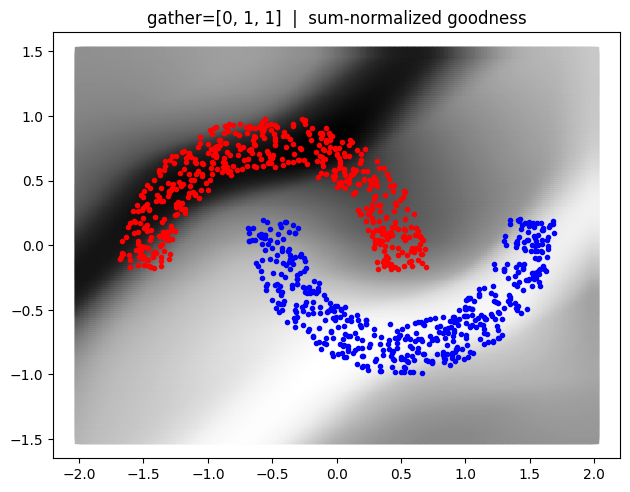

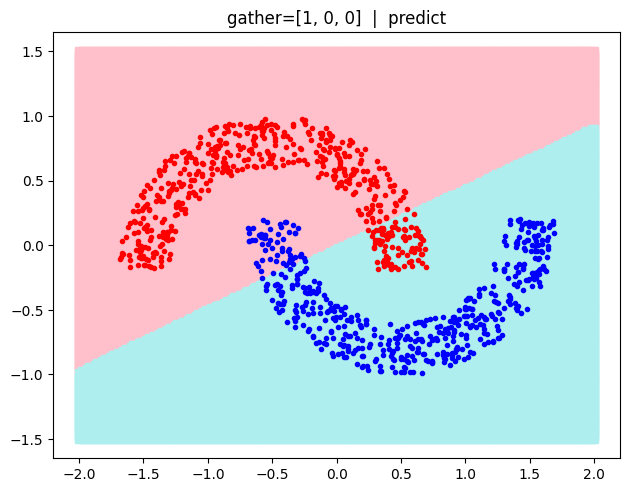

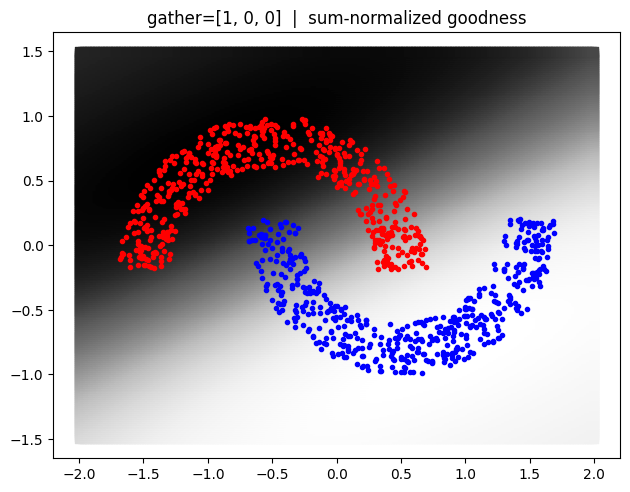

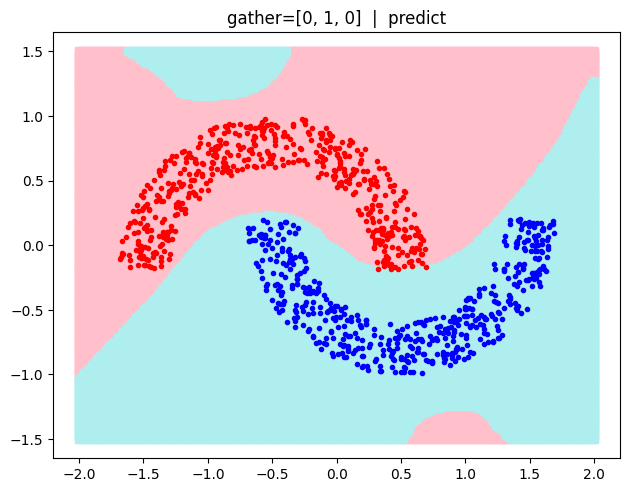

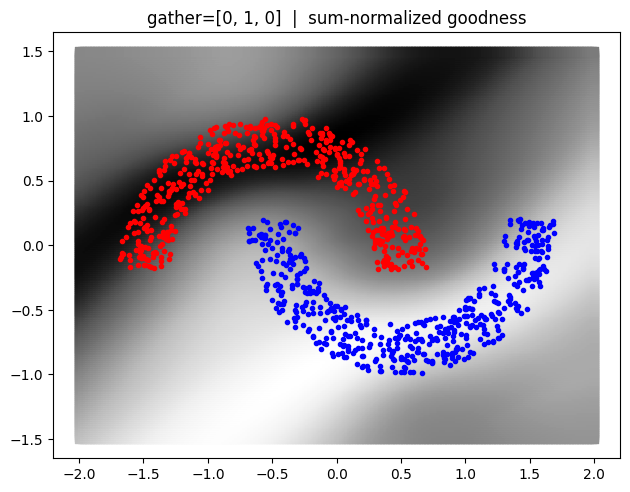

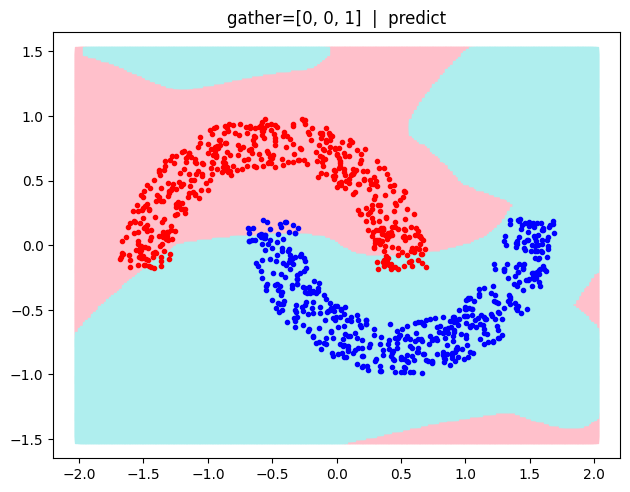

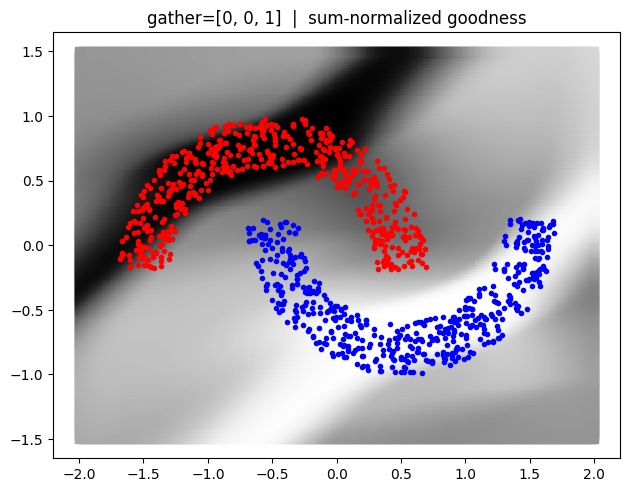

In [7]:
x_gr = twomoon.grid_sample()
x_gr_th = th.from_numpy(x_gr).float().to(device)

gathers = [
    [1, 1, 1],
    [0, 1, 1],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]   
]

print("gather     accuracy%")

for gather in gathers:
    
    M.gather.data = th.tensor(gather, device=device).float()
    print(f"{gather}  {(1-M.TS_loop(TS_dl))*100:.5g}")
    
    y_gr = M.predict(x_gr_th).cpu().numpy()
    twomoon.plot(x_gr, y_gr)
    plt.title(f"gather={gather}  |  predict")
    
    proba = M.sum_normalized_goodness(x_gr_th).cpu().numpy()
    twomoon.plot_proba(x_gr, proba[:,1])
    plt.title(f"gather={gather}  |  sum-normalized goodness")

#### Different initializations different results?

In [8]:
M = th.load('final models/' + exp_name + '.pt').to(device)

N_trials = 5
TS_acc = []
for i in range(N_trials):
    M.fit(DS_pndl)
    this_trial_results = []
    for gather in gathers:
        M.gather.data = th.tensor(gather, device=device).float()
        this_trial_results.append((1-M.TS_loop(TS_dl))*100)  
    TS_acc.append(this_trial_results)   
TS_acc = np.asarray(TS_acc)
TS_mean = np.mean(TS_acc, axis=0)
TS_std = np.std(TS_acc, axis=0, ddof=1)

print("gather     accuracy%")
for i in range(len(gathers)):
    print(f"{gathers[i]}  {TS_mean[i]:.5g} +- {TS_std[i]:.5g}")

gather     accuracy%
[1, 1, 1]  97.2 +- 0.44721
[0, 1, 1]  98.2 +- 1.0954
[1, 0, 0]  86.5 +- 0
[0, 1, 0]  100 +- 0
[0, 0, 1]  94 +- 2.2638
